In [223]:
# Task 1

import torchvision
import torch
import numpy as np

In [224]:
train_set = torchvision.datasets.MNIST(
   root="./data",
   download=True,
   train=True,
   transform=torchvision.transforms.ToTensor()
)
test_set = torchvision.datasets.MNIST(
   root="./data",
   download=True,
   train=False,
   transform=torchvision.transforms.ToTensor()
)

amount = 500
batch_size = 100
epochs = 1
workers = 8

# torch.data.random_split
shuffled_ind = np.random.permutation(np.arange(len(train_set)))

calibration_set = torch.utils.data.Subset(train_set, shuffled_ind[:amount])
train_set = torch.utils.data.Subset(train_set, shuffled_ind[amount:])

# create Dataloaders
train_loader = torch.utils.data.DataLoader(train_set, shuffle=True, batch_size=batch_size, num_workers=8)
calibration_loader = torch.utils.data.DataLoader(calibration_set, shuffle=True, batch_size=batch_size, num_workers=8)
test_loader = torch.utils.data.DataLoader(test_set, shuffle=False, batch_size=batch_size, num_workers=8)


In [225]:
#Bad Net
import pytorch_lightning as pl
from torch import nn
from torch.nn import functional
import torch

class BadNet(pl.LightningModule):

    def __init__(self):
        super(BadNet, self).__init__()        
        self.conv1 = torch.nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
            ),                              
            nn.ReLU(),                      
            nn.AvgPool2d(kernel_size=(2, 2), stride=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(
                in_channels=16, 
                out_channels=32, 
                kernel_size=5, 
                stride=1),     
            nn.ReLU(),                      
            nn.AvgPool2d(kernel_size=(2, 2), stride=2),                
        )
        self.f1 = nn.Sequential(
            nn.Linear(in_features=(32 * 4 * 4), out_features=512),
            nn.ReLU(),
        )
        # fully connected layer, output 10 classes
        self.out = nn.Sequential(
            nn.Linear(in_features=512, out_features=10),
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)        
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        x = self.f1(x)
        output = self.out(x)
        return output

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        # it is independent of forward
        x, y = batch
        out = self.forward(x)

        loss = nn.functional.cross_entropy(out, y)
        self.log("train_loss", loss)
        return loss

    def test_step(self, batch, batch_idx):
        # this is the test loop
        x, y = batch
        out = self.forward(x)
        test_loss = nn.functional.cross_entropy(out, y)
        self.log("test_loss", test_loss)

    def backward(self, loss, optimizer, optimizer_idx):
        loss.backward(retain_graph=True)

    def validation_step(self, batch, batch_idx):
        x, y = batch
        out = self.forward(x)
        validiation_loss = nn.functional.cross_entropy(out, y)
        self.log("validation_loss", validiation_loss)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [226]:
bad_net = BadNet()
trainer = pl.Trainer(max_epochs=epochs)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [227]:
trainer.fit(model=bad_net, train_dataloaders=train_loader)

/home/paul/workspaces/PycharmProjects/trustworthy_machine_learning/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:133: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.")

  | Name  | Type       | Params
-------------------------------------
0 | conv1 | Sequential | 416   
1 | conv2 | Sequential | 12.8 K
2 | f1    | Sequential | 262 K 
3 | out   | Sequential | 5.1 K 
-------------------------------------
281 K     Trainable params
0         Non-trainable params
281 K     Total params
1.124     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

In [228]:
# get accuracy and confidence for the calibration set
from tqdm.notebook import tqdm
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

def evaluate_network(model, dataloader, calibration_method=None):
    model.eval()
    predictions = []
    labels = []
    correct = 0
    with torch.no_grad():
        
        for x, y in tqdm(dataloader):
            prediction:torch.Tensor = model(x)

            if calibration_method:
                prediction = calibration_method(prediction)

            prediction = nn.functional.softmax(prediction, dim=1)

            _, predicted_label = torch.max(prediction, dim=1)
            label_oh = nn.functional.one_hot(y, num_classes=10)
            predictions.extend(prediction.detach().numpy())
            labels.extend(label_oh.detach().numpy())
            correct += sum(predicted_label == y)
            
    acc = correct / len(dataloader.dataset)
    predictions = np.array(predictions)
    labels = np.array(labels)

    return acc, predictions, labels


def calc_bins(predictions, labels, num_bins=10):
    # Assign each prediction to a bin
    bins = np.linspace(0.1, 1, num_bins)
    binned = np.digitize(predictions, bins)

    # Save the accuracy, confidence and size of each bin
    bin_accs = np.zeros(num_bins)
    bin_confs = np.zeros(num_bins)
    bin_sizes = np.zeros(num_bins, dtype=np.int64)

    for bin in range(num_bins):
        current_bin = (binned == bin)
        bin_sizes[bin] = len(predictions[current_bin])
        if bin_sizes[bin] > 0:
            bin_accs[bin] = (labels[current_bin]).sum() / bin_sizes[bin]
            bin_confs[bin] = (predictions[current_bin]).sum() / bin_sizes[bin]

    return bins, binned, bin_accs, bin_confs, bin_sizes


def expected_calibration_error(bin_accs, bin_confs, bin_sizes):
    return sum([(bs / sum(bin_sizes)) * abs(ba - bc) for (ba, bc, bs) in zip(bin_accs, bin_confs, bin_sizes)])


def draw_reliability_graph(bins, bin_accs, ece):

    fig = plt.figure(figsize=(8, 8))
    ax = fig.gca()

    # x/y limits
    ax.set_xlim(0, 1.05)
    ax.set_ylim(0, 1)

    # x/y labels
    plt.xlabel('Confidence')
    plt.ylabel('Accuracy')

    # Create grid
    ax.set_axisbelow(True) 
    ax.grid(color='gray', linestyle='dashed')

    # Error bars
    plt.bar(bins, bins,  width=0.1, alpha=0.3, edgecolor='black', color='r', hatch='\\')

    # Draw bars and identity line
    plt.bar(bins, bin_accs, width=0.1, alpha=1, edgecolor='black', color='b')
    plt.plot([0,1],[0,1], '--', color='gray', linewidth=2)

    ECE_patch = mpatches.Patch(color='green', label='ECE = {:.2f}%'.format(ece*100))
    plt.legend(handles=[ECE_patch])

    # Equally spaced axes
    plt.gca().set_aspect('equal', adjustable='box')

    plt.show()


def present_result(model, dataloader, calibration_method=None):
    acc, preds, labels = evaluate_network(model, dataloader, calibration_method=calibration_method)
    bins, _, bin_accs, bin_confs, bin_sizes= calc_bins(preds, labels)
    ece = expected_calibration_error(bin_accs, bin_confs, bin_sizes)
    draw_reliability_graph(bins, bin_accs, ece)


  0%|          | 0/5 [00:00<?, ?it/s]

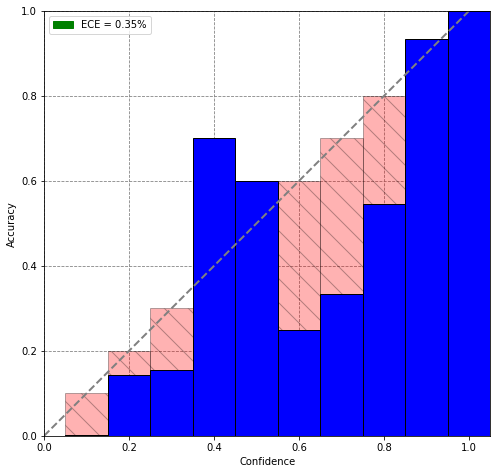

In [229]:
present_result(bad_net, calibration_loader)

In [230]:
# Part c

def temperature_scaling(logits, temperature):
    return torch.div(logits, temperature)

def get_logits(model, dataloader):
    logits = []
    labels = []
    model.eval()

    for x, y in tqdm(dataloader):
        with torch.no_grad():
            logits.append(model(x))
            labels.append(y)
    
    return torch.cat(logits), torch.cat(labels)
      

In [231]:
logits, labels = get_logits(bad_net, calibration_loader)

  0%|          | 0/5 [00:00<?, ?it/s]

In [232]:
temperature = nn.Parameter(torch.ones(1))
optimizer = torch.optim.LBFGS([temperature], lr=0.001, max_iter=1000, line_search_fn="strong_wolfe")

temps = []
losses = []

logits, labels = get_logits(bad_net, calibration_loader)

print(logits.shape, labels.shape)
def _eval():
  loss = nn.functional.cross_entropy(temperature_scaling(logits, temperature), labels)
  loss.backward()
  temps.append(temperature.detach().numpy())
  losses.append(loss.detach().numpy())
  return loss


optimizer.step(_eval)


  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([500, 10]) torch.Size([500])


tensor(0.0827, grad_fn=<NllLossBackward0>)

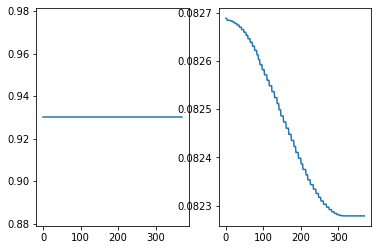

In [235]:
plt.subplot(121)
plt.plot(list(range(len(temps))), temps)

plt.subplot(122)
plt.plot(list(range(len(losses))), losses)
plt.show()

  0%|          | 0/5 [00:00<?, ?it/s]

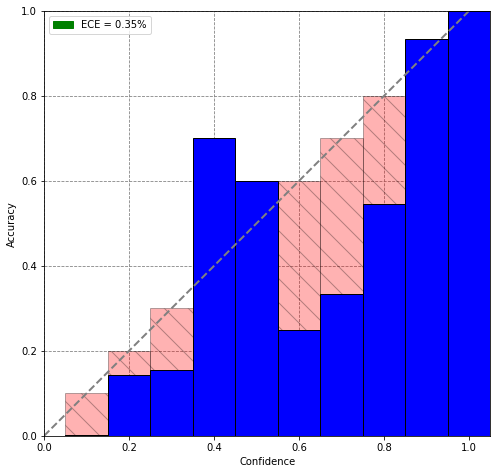

  0%|          | 0/5 [00:00<?, ?it/s]

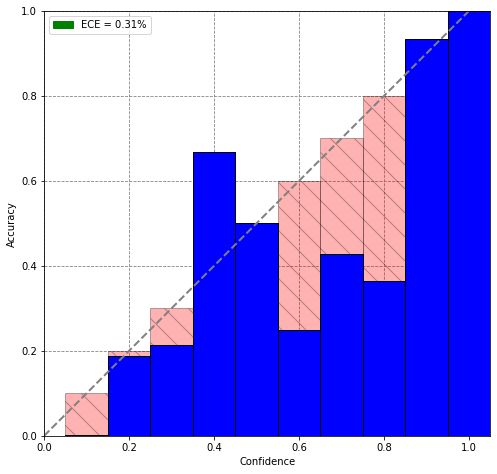

In [234]:
from functools import partial

pt = partial(temperature_scaling, temperature=temperature)

present_result(bad_net, calibration_loader)
present_result(bad_net, calibration_loader, calibration_method=pt)



# Task 2 Conformal Predictions

In [270]:
def calc_prediction_sets(model, calibration_loader, test_loader, alpha=0.3):
    calib_logits, calib_y = get_logits(model, calibration_loader)
    n = len(calibration_loader)

    probs = calib_logits.softmax(dim=1)

    scores = 1 - torch.gather(probs, 1, calib_y.unsqueeze(dim=1))
    print(scores.shape)
    qhat = torch.quantile(scores, np.ceil((n + 1) * (1 - alpha))/n)
    print(qhat)

    test_logits, test_y = get_logits(model, test_loader)
    smx = test_logits.softmax(dim=1)

    return (smx > (1 - qhat)).nonzero()

In [271]:
prediction_sets = calc_prediction_sets(bad_net, calibration_loader, test_loader)

  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([500, 1])
tensor(0.9874)


  0%|          | 0/100 [00:00<?, ?it/s]

In [247]:
from collections import defaultdict
prediction_sets_ = defaultdict(list)

for ps in prediction_sets:
    a = prediction_sets_[ps[0].item()] 
    a.append(ps[1].item())


In [261]:
hist = defaultdict(lambda: 0)
for i, ps in prediction_sets_.items():
    hist[len(ps)] += 1

bins = np.array(list(hist.keys()))
values = np.array(list(hist.values()))

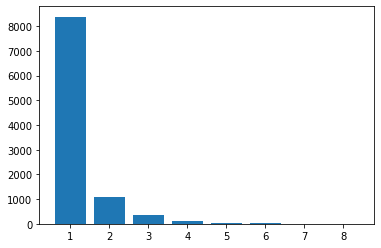

In [267]:
plt.bar(bins, values)
plt.show()

In [280]:
# The algorithm is also present in the linked paper, so just copy and paste as before
def calc_better_prediction_sets(model, calibration_loader, test_loader, alpha=0.3):
    n = len(calibration_loader)
    logits_calib, y = get_logits(model, calibration_loader)
    sorted, pi = logits_calib.softmax(dim=1).sort(dim=1, descending=True)
    scores = sorted.cumsum(dim=1).gather(1, pi.argsort(1))[range(y.shape[0]), y]
    print(scores.shape)

    qhat = torch.quantile(scores, np.ceil((n + 1) * (1 - alpha)) / n)

    logits_test, _ = get_logits(model, test_loader)
    test_sorted, test_pi = logits_test.softmax(dim=1).sort(dim=1, descending=True)
    sizes = (test_sorted.cumsum(dim=1) > qhat).int().argmax(dim=1)
    
    return [test_pi[i][:(sizes[i] + 1)] for i in range(sizes.shape[0])]

In [281]:
predictions_sets_2 = calc_better_prediction_sets(bad_net, calibration_loader, test_loader)

  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([500])


  0%|          | 0/100 [00:00<?, ?it/s]

10000


In [290]:
prediction_sets_2_ = defaultdict(list)

for i, ps in enumerate(predictions_sets_2):
    prediction_sets_2_[i] = ps.detach().numpy()

[tensor([7]), tensor([2]), tensor([1]), tensor([0]), tensor([4])]


In [300]:
hist_2 = defaultdict(lambda: 0)
for i, ps in prediction_sets_.items():
    hist_2[len(ps)] += 1

bins_2 = np.array(list(hist_2.keys()))
values_2 = np.array(list(hist_2.values()))

In [301]:
print(bins_2, values_2)

[1 2 4 3 6 5 7 8] [8380 1086  109  342   20   50   11    2]


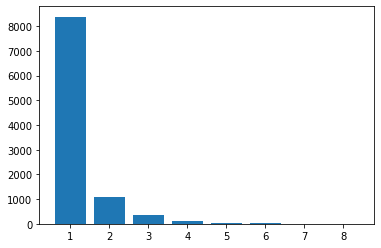

In [302]:
plt.bar(bins_2, values_2)
plt.show()